In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from GraphLaplacian.binary import GraphLaplacian, MBOBinary
from GraphLaplacian.multilabel import GLMultiClass, MBOMultiClass
from GraphLaplacian.helper import plot, plot2d
import pdb
from IPython.display import clear_output
from sklearn.datasets import make_moons, make_circles, make_classification
import scipy
import pdb
from datetime import datetime
import itertools

matplotlib.rcParams['figure.figsize'] = [5, 5]
sns.set()
sns.set_style("ticks")

In [2]:
import random
import math

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def create_score_sheet(method, y_true, y_pred):
    return {"Method":method, 
            "accuracy":accuracy_score(y_true, y_pred), 
            "f1_score": f1_score(y_true, y_pred), 
            "presicion": precision_score(y_true, y_pred), 
            "recall": recall_score(y_true, y_pred)}

def find_h(X, n_sample=5, n_neigh=5, use_mean=False):
    np.random.seed(1000)
    tree = scipy.spatial.cKDTree(X)
    sample = random.sample(X, k=n_sample)
    _func = lambda point: np.mean([x for x in tree.query(point, k = n_neigh+1)[0] if x > 0])
    if use_mean:
        h = np.mean([_func(x) for x in sample])
    else:
        h = np.max([_func(x) for x in sample])
    return h

# Xr = random.choices(X, k=10)

In [3]:
colors = ["#ffffff", "#ff6361", "#003f5c", "#63005c", "#006355", "#5c3f00"]
sns.set_palette(sns.color_palette(colors))

In [4]:
wcut_to_denum = lambda x: np.sqrt(-2*np.log(x))
denum_to_wcut = lambda x: np.exp(-(x**2)/2)

In [5]:
denum_to_wcut(6)

1.522997974471263e-08

In [6]:
def plot_case(X0, Y0, X1, return_ax=False, title=""):
    colors = ["#ed705c", "#79b1ed", "#ffb3ff", "#82d4d1", "#f5dd9f"]
    sns.set_palette(sns.color_palette(colors))

    xx = [x[0] for x in X1]
    xy = [x[1] for x in X1]
    max_lim = max(max(xx), max(xy)) + 0.1
    min_lim = min(min(xx), min(xy)) + 0.1

    fig, ax = plt.subplots()
    ax.scatter(xx, xy, label="unknown", s=7, color="#cccccc")

    df = pd.DataFrame(X0, columns=["x1", "x2"])
    df.loc[:, "label"] = ["Initial_" + str(Y0[i]) if i < len(Y0) else "unknown" for i, y in enumerate(X0)]
    df = df.sort_values(by=["label"], ascending=True)
    colors = ["#691b05", "#071e7a", "#690664", "#006355", "#5c3f00"]
    for i, label in enumerate(df[df["label"] != "unknown"].label.unique()):
        dplot = df[df["label"] == label]
        ax.scatter(dplot["x1"], dplot["x2"], label=label, s=20, marker="x", color=colors[i])
    # ax.scatter(np.array(X0).T[0], np.array(X0).T[1], label="Initial Data", s=15, marker="x", color="red")

    ax.set_xlim(min_lim, max_lim)
    ax.set_ylim(min_lim, max_lim)
    ax.set_title(title)

    ax.legend()
    if return_ax:
        return ax
    plt.show()

# a

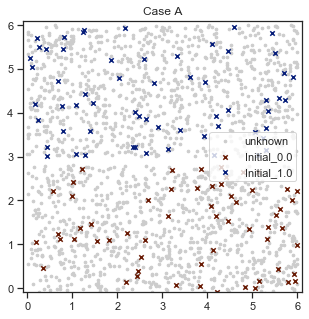

In [9]:
np.random.seed(1000)
blue = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 + 3))
red = list(zip(np.random.random(1000)*6, np.random.random(1000)*3 - 0.2))
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)

N = 60
gamma = 1
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]
plot_case(X0, Y0, X1, title="Case A")

In [35]:
h = find_h(X, len(X), 1, use_mean=False)/3.6

In [36]:
denums = [1, 2, 3, 3.6, 4, 5]
dataa = list()
for d in denums:
    h = find_h(X, len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=w_cut)
    GL.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, GL.Y)
    dataa.append({"Alg":"GL", "denum":d, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})

Graph Laplacian, denum=1
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.8926952141057934}
Graph Laplacian, denum=2
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.8998998998998999}
Graph Laplacian, denum=3
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.9}
Graph Laplacian, denum=3.6
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.9}
Graph Laplacian, denum=4
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.9}
Graph Laplacian, denum=5
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.8938097634625063}


In [56]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))
dataa_mbo = list()
for d, t in pairs:
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
    mbo.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, mbo.Y)
    dataa_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})

MBO, (denum, dT) : (1, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.644718792866941
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.7565066512434934}
MBO, (denum, dT) : (1, 0.01)
Calculate weight matrix... DONE
Interation 0 error 1.0681818181818181
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.5472222222222223}
MBO, (denum, dT) : (1, 0.005)
Calculate weight matrix... DONE
Interation 0 error 1.0681818181818181
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.5472222222222223}
MBO, (denum, dT) : (1, 0.001)
Calculate weight matrix... DONE
Interation 0 error 1.0681818181818181
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.5472222222222223}
MBO, (denum, dT) : (2, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.7654723127035831
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.1, 'denum': 2, 'f1-score': 0.6815365551425031}
MBO, (denum, dT) : (2, 0.01)
Calcula

In [57]:
dataa_mbo

[{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.7565066512434934},
 {'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.5472222222222223},
 {'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.5472222222222223},
 {'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.5472222222222223},
 {'Alg': 'MBO', 'dT': 0.1, 'denum': 2, 'f1-score': 0.6815365551425031},
 {'Alg': 'MBO', 'dT': 0.01, 'denum': 2, 'f1-score': 0.501086169442433},
 {'Alg': 'MBO', 'dT': 0.005, 'denum': 2, 'f1-score': 0.501086169442433},
 {'Alg': 'MBO', 'dT': 0.001, 'denum': 2, 'f1-score': 0.501086169442433},
 {'Alg': 'MBO', 'dT': 0.1, 'denum': 3, 'f1-score': 0.5384615384615384},
 {'Alg': 'MBO', 'dT': 0.01, 'denum': 3, 'f1-score': 0.39028213166144204},
 {'Alg': 'MBO', 'dT': 0.005, 'denum': 3, 'f1-score': 0.39028213166144204},
 {'Alg': 'MBO', 'dT': 0.001, 'denum': 3, 'f1-score': 0.39028213166144204},
 {'Alg': 'MBO', 'dT': 0.1, 'denum': 3.6, 'f1-score': 0.48311306901615275},
 {'Alg': 'MBO', 'dT': 0.01, 'denum': 3.6, 'f1-

# b

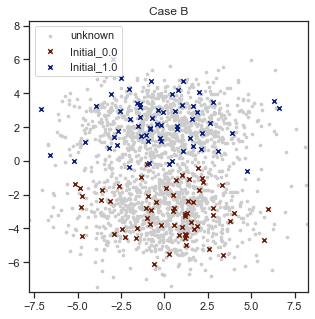

In [10]:
np.random.seed(1000)
cov1 = np.array([[6,0],[0,2]])
blue = np.random.multivariate_normal(mean=[0,2], cov=cov1, size=1000)
cov2 = np.array([[6,0],[0,2]])
red = np.random.multivariate_normal(mean=[0,-3], cov=cov2, size=1000)
Y = list(np.ones(len(blue))) + list(np.ones(len(red))*0)
X = list(blue) + list(red)
h = find_h(X, len(X), 1, use_mean=False)/3.6

N = 60
gamma = 1
X0 = list(blue[:N]) + list(red[:gamma*N])
Y0 = list(np.ones(len(blue)))[:N] + list(np.ones(len(red))*0)[:gamma*N]
X1 = list(blue[N:]) + list(red[gamma*N:])
Y1 = list(np.ones(len(blue)))[N:] + list(np.ones(len(red))*0)[gamma*N:]

plot_case(X0, Y0, X1, title="Case B")

In [38]:
denums = [1, 2, 3, 3.6, 4, 5]
datab = list()
for d in denums:
    h = find_h(X, len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    w_cut = 0.001 if (denum_to_wcut(d)*0.99)>0.001 else denum_to_wcut(d)*0.99
    GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=w_cut)
    GL.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, GL.Y)
    datab.append({"Alg":"GL", "denum":d, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})

Graph Laplacian, denum=1
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.0392156862745098}
Graph Laplacian, denum=2
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.0392156862745098}
Graph Laplacian, denum=3
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.8154599891126838}
Graph Laplacian, denum=3.6
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.8642745709828393}
Graph Laplacian, denum=4
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.8785238339313172}
Graph Laplacian, denum=5
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.8870886075949366}


In [59]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))
datab_mbo = list()
for d, t in pairs:
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
    mbo.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, mbo.Y)
    datab_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})

MBO, (denum, dT) : (1, 0.1)
Calculate weight matrix... DONE
Interation 0 error 1.3946587537091988
Interation 1 error 15.85
Interation 2 error 0.0
{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.0392156862745098}
MBO, (denum, dT) : (1, 0.01)
Calculate weight matrix... DONE
Interation 0 error 0.5845771144278606
Interation 1 error 0.014705882352941176
Interation 2 error 0.0072992700729927005
Interation 3 error 0.0024271844660194173
Interation 4 error 0.0012121212121212121
Interation 5 error 0.0024183796856106408
Interation 6 error 0.0
{'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.8133552271483305}
MBO, (denum, dT) : (1, 0.005)
Calculate weight matrix... DONE
Interation 0 error 0.5676328502415459
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.8140043763676149}
MBO, (denum, dT) : (1, 0.001)
Calculate weight matrix... DONE
Interation 0 error 0.556872037914692
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.8232104121475055

In [70]:
df = pd.DataFrame(datab_mbo)
#df.loc[:, "f1-score"] = df["f1-score"]*100
df = df.pivot("dT", "denum", "f1-score").reset_index()
df.sort_values(["dT"], ascending=False)

denum,dT,1.0,2.0,3.0,3.6,4.0,5.0
3,0.100,0.039216,0.883223,0.891469,0.891019,0.885960,0.888664
2,0.010,0.813355,0.840873,0.873457,0.880490,0.885163,0.881753
1,0.005,0.814004,0.848997,0.874165,0.880612,0.885163,0.834047
0,0.001,0.823210,0.854593,0.869520,0.869655,0.864977,0.849604


# c

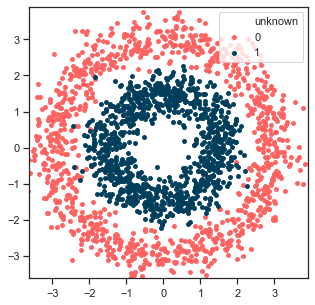

In [96]:
X, Y = make_circles(noise=0.11, factor=0.5, random_state=1, n_samples=2000)
X = X * 3

plot(X,Y,[])

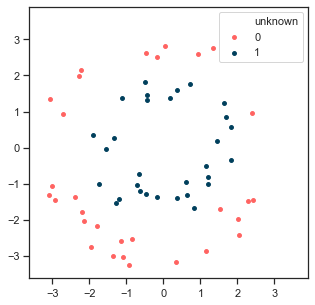

In [98]:
N = 30
gamma = 1
X0 = list([X[i] for i,y in enumerate(Y) if y==0][:N] + [X[i] for i,y in enumerate(Y) if y==1][:gamma*N])
Y0 = list([y for y in Y if y==0][:N] + [y for y in Y if y==1][:gamma*N])
X1 = list(X[(1+gamma)*N:])
# X = X0 + X1
plot(X0, Y0, X1)

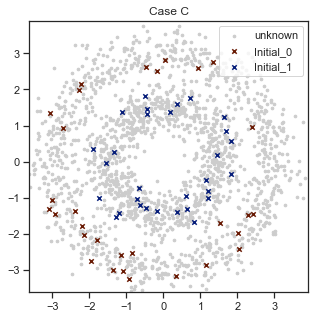

In [99]:
plot_case(X0, Y0, X1, title="Case C")

In [41]:
denums = [1, 2, 3, 3.6, 4, 5]
datac = list()
for d in denums:
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("Graph Laplacian, denum={}".format(d))
    GL = GraphLaplacian(X0, Y0, X1, sigma=h, w_cut=denum_to_wcut(d)*0.99)
    GL.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, GL.Y)
    datac.append({"Alg":"GL", "denum":d, "f1-score":score})
    print({"Alg":"GL", "denum":d, "f1-score":score})

Graph Laplacian, denum=1
{'Alg': 'GL', 'denum': 1, 'f1-score': 0.9688273132112815}
Graph Laplacian, denum=2
{'Alg': 'GL', 'denum': 2, 'f1-score': 0.9712301587301587}
Graph Laplacian, denum=3
{'Alg': 'GL', 'denum': 3, 'f1-score': 0.9721393034825871}
Graph Laplacian, denum=3.6
{'Alg': 'GL', 'denum': 3.6, 'f1-score': 0.9716276754604282}
Graph Laplacian, denum=4
{'Alg': 'GL', 'denum': 4, 'f1-score': 0.9706028898854012}
Graph Laplacian, denum=5
{'Alg': 'GL', 'denum': 5, 'f1-score': 0.9705441837244133}


In [54]:
denums = [1, 2, 3, 3.6, 4, 5]
dts = [0.1, 0.01, 0.005, 0.001]
pairs = list(itertools.product(denums, dts))
datac_mbo = list()
for d, t in pairs:
    h = find_h(list(X), len(X), 1, use_mean=False)/d
    print("MBO, (denum, dT) : ({}, {})".format(d, t))
    mbo = MBOBinary(X0, Y0, X1, sigma=h, dT=t, w_cut=denum_to_wcut(d)*0.99, initial="0.5")
    mbo.solve()
    #plot2d(GL, title=r"GL, $\sigma=D/{}$".format(h))
    score = f1_score(Y, mbo.Y)
    datac_mbo.append({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})
    print({"Alg":"MBO", "dT":t,  "denum":d, "f1-score":score})

MBO, (denum, dT) : (1, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.4727095516569201
Interation 1 error 0.0058823529411764705
Interation 2 error 0.0019646365422396855
Interation 3 error 0.001968503937007874
Interation 4 error 0.0
{'Alg': 'MBO', 'dT': 0.1, 'denum': 1, 'f1-score': 0.9702380952380953}
MBO, (denum, dT) : (1, 0.01)
Calculate weight matrix... DONE
Interation 0 error 0.47317073170731705
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.01, 'denum': 1, 'f1-score': 0.9639506172839506}
MBO, (denum, dT) : (1, 0.005)
Calculate weight matrix... DONE
Interation 0 error 0.474559686888454
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.005, 'denum': 1, 'f1-score': 0.9624134520276955}
MBO, (denum, dT) : (1, 0.001)
Calculate weight matrix... DONE
Interation 0 error 0.48597194388777554
Interation 1 error 0.0
{'Alg': 'MBO', 'dT': 0.001, 'denum': 1, 'f1-score': 0.9669669669669669}
MBO, (denum, dT) : (2, 0.1)
Calculate weight matrix... DONE
Interation 0 error 0.4717898832684825
Inter

In [71]:
df = pd.DataFrame(datac_mbo)
#df.loc[:, "f1-score"] = df["f1-score"]*100
df = df.pivot("dT", "denum", "f1-score").reset_index()
df.sort_values(["dT"], ascending=False)

denum,dT,1.0,2.0,3.0,3.6,4.0,5.0
3,0.100,0.970238,0.963475,0.963366,0.961787,0.962189,0.960725
2,0.010,0.963951,0.960474,0.941783,0.907930,0.894283,0.842105
1,0.005,0.962413,0.964304,0.941783,0.907930,0.897959,0.853303
0,0.001,0.966967,0.964304,0.941783,0.908511,0.897959,0.871145


# multi

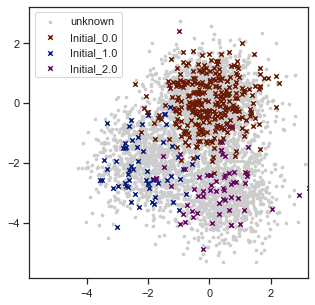

In [92]:
np.random.seed(1000)
cov = np.array([[0.7,0],[0,0.7]])
one = np.random.multivariate_normal(mean=[0,0], cov=cov, size=2000)
two = np.random.multivariate_normal(mean=[-2,-2], cov=cov, size=1000)
tree = np.random.multivariate_normal(mean=[0.5,-3], cov=cov, size=1000)

N0 = 60
N01 = 5*N0
N02 = N0
N03 = N0
X0 = list(one[:N01]) + list(two[:N02]) + list(tree[:N03])
Y0 = list(np.ones(N01)*0) + list(np.ones(N02)*1) + list(np.ones(N03)*2)
X1 = list(one[N01:]) + list(two[N02:]) + list(tree[N03:])
Y1 = list(np.ones(len(one) - N01)*0) + list(np.ones(len(two) - N02)*1) + list(np.ones(len(tree) - N03)*2)
X = list(X0) + list(X1)
Y = list(Y0) + list(Y1)

#Xr = random.choices(X, k=100)
h = find_h(X, len(X), 1, use_mean=False)/3.6
plot_case(X0, Y0, X1)